In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
pd.options.display.float_format = '{:,.4f}'.format

In [3]:
customers = pd.read_excel('/Users/thoitruong/Documents/Portfolio/customers.xlsx')
transactions = pd.read_excel('/Users/thoitruong/Documents/Portfolio/transactions.xlsx')

### 1. **RFM**

In [4]:
SNAPSHOT_DATE = transactions["transaction_date"].max() + pd.Timedelta(days=1)
print("snapshot_date: ", SNAPSHOT_DATE)
rfm = (
    transactions
    .groupby("customer_id")
    .agg({
        "transaction_date": lambda x: (SNAPSHOT_DATE - x.max()).days,
        "customer_id": "count",
        "amount": "sum"
    })
    .rename(columns={
        "transaction_date": "recency",
        "customer_id": "frequency",
        "amount": "monetary"
    })
    .reset_index()
)

rfm.head()

snapshot_date:  2026-01-01 00:00:00


,customer_id,recency,frequency,monetary
0,C00000,1,12,1222.85
1,C00001,12,19,1228.46
2,C00002,97,11,910.64
3,C00003,44,4,114.71
4,C00004,109,19,2018.94


In [5]:
rfm.shape

(2892, 4)

In [6]:
rfm.describe()

,recency,frequency,monetary
count,2892.000000,2892.000000,2892.000000
mean,88.207123,16.149378,940.920654
std,90.953968,17.138352,1206.226060
min,1.000000,1.000000,1.700000
25%,7.000000,5.000000,206.612500
50%,55.000000,11.000000,538.440000
75%,155.000000,21.000000,1212.687500
max,354.000000,155.000000,13966.820000


In [7]:
rfm_q = rfm.copy()

# Recency: nhỏ tốt → score cao
rfm_q["R_score"] = pd.qcut(
    rfm_q["recency"],
    q=5,
    labels=[5, 4, 3, 2, 1]
)

# Frequency: lớn tốt
rfm_q["F_score"] = pd.qcut(
    rfm_q["frequency"],
    q=5,
    labels=[1, 2, 3, 4, 5]
)

# Monetary: lớn tốt
rfm_q["M_score"] = pd.qcut(
    rfm_q["monetary"],
    q=5,
    labels=[1, 2, 3, 4, 5]
)

rfm_q[["customer_id", "R_score", "F_score", "M_score"]].head()

,customer_id,R_score,F_score,M_score
0,C00000,5,3,4
1,C00001,4,4,4
2,C00002,2,3,4
3,C00003,3,1,1
4,C00004,2,4,5


In [8]:
rfm_q["RFM_score"] = (
    rfm_q["R_score"].astype(str) +
    rfm_q["F_score"].astype(str) +
    rfm_q["M_score"].astype(str)
)

rfm_q[["customer_id", "RFM_score"]].head()

,customer_id,RFM_score
0,C00000,534
1,C00001,444
2,C00002,234
3,C00003,311
4,C00004,245


In [9]:
def rfm_segment(row):
    r, f, m = int(row["R_score"]), int(row["F_score"]), int(row["M_score"])

    if r >= 4 and f >= 4 and m >= 4:
        return "Champions"

    if r >= 4 and f >= 3:
        return "Loyal Customers"

    if r >= 4 and f <= 2:
        return "New Customers"

    if r <= 2 and f >= 3:
        return "At Risk"

    if r <= 2 and f <= 2:
        return "Hibernating"

    return "Others"

rfm_q["rfm_segment"] = rfm_q.apply(rfm_segment, axis=1)
rfm_q[["customer_id", "RFM_score", "rfm_segment"]].head()

,customer_id,RFM_score,rfm_segment
0,C00000,534,Loyal Customers
1,C00001,444,Champions
2,C00002,234,At Risk
3,C00003,311,Others
4,C00004,245,At Risk


In [10]:
# Tính số lượng và tỷ lệ phần trăm
counts = rfm_q["rfm_segment"].value_counts()
percentages = rfm_q["rfm_segment"].value_counts(normalize=True) * 100

# Gộp thành một bảng tổng hợp
summary_table = pd.concat([counts, percentages], axis=1)
summary_table.columns = ['Count', 'Percentage (%)']

segment_order = [
    "Champions", 
    "Loyal Customers", 
    "New Customers", 
    "At Risk", 
    "Hibernating", 
    "Others"
]

summary_table.reindex(segment_order).reset_index().style.format({'Percentage (%)': '{:.2f}%'})

,rfm_segment,Count,Percentage (%)
0,Champions,578,19.99%
1,Loyal Customers,368,12.72%
2,New Customers,216,7.47%
3,At Risk,473,16.36%
4,Hibernating,681,23.55%
5,Others,576,19.92%


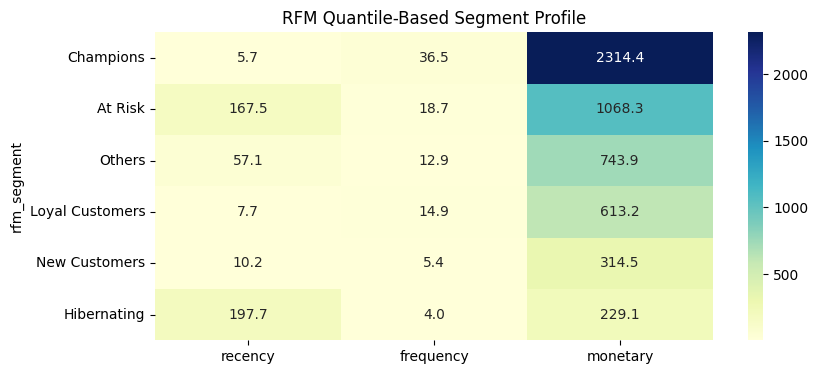

In [11]:
segment_profile_q = (
    rfm_q
    .groupby("rfm_segment")[["recency", "frequency", "monetary"]]
    .mean()
    .sort_values("monetary", ascending=False)
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 4))
sns.heatmap(
    segment_profile_q,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu"
)
plt.title("RFM Quantile-Based Segment Profile")
plt.show()

In [ ]:
# transactions.merge(customers, on='customer_id').groupby('customer_id').apply(lambda g: (g['transaction_date'].min() - g['signup_date'].min())).dt.days.describe([0.75,0.9])

In [13]:
transactions['gap_days'] = (transactions['transaction_date'] - transactions.groupby('customer_id')['transaction_date'].shift(1)).dt.days

In [14]:
transactions['gap_days'].describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.98])

count    43812.000000
mean         6.307245
std          9.344010
min          0.000000
25%          1.000000
50%          3.000000
75%          8.000000
90%         16.000000
95%         23.000000
98%         34.000000
max        167.000000
Name: gap_days, dtype: float64

In [34]:
INACTIVITY_WINDOW = np.floor((transactions['gap_days'].quantile(0.98) + transactions['gap_days'].quantile(0.95))/2) + 1

In [35]:
rfm_q['churn_label'] = np.where(rfm_q['recency'] > INACTIVITY_WINDOW,1,0)

In [36]:
pd.crosstab(
    rfm_q["churn_label"],          # KMeans segment
    rfm_q["rfm_segment"]     # RFM rule-based
)

rfm_segment,At Risk,Champions,Hibernating,Loyal Customers,New Customers,Others
churn_label,,,,,,
0,0,578,0,368,216,26
1,473,0,681,0,0,550


In [99]:
def return_probability_by_gap(df, max_days=180):
    gaps = df.dropna()

    results = []
    for d in range(1, max_days + 1):
        # customers who were inactive at least d days
        at_risk = (gaps >= d).sum()

        # customers who returned after exactly that gap
        returned = (gaps == d).sum()

        prob_return = returned / at_risk if at_risk > 0 else np.nan

        results.append({
            'inactive_days': d,
            'prob_return': prob_return
        })

    return pd.DataFrame(results)

In [105]:
ret_prob = return_probability_by_gap(transactions['transaction_gap'])
cutoff_day = (
    ret_prob
    .loc[ret_prob['prob_return'] < 0.07, 'inactive_days']
    .min()
)

print(
    f"After {cutoff_day} days of inactivity, "
    f"probability of return drops below 7%."
)


After 27 days of inactivity, probability of return drops below 7%.


### **2. Churn via Classification**

In [16]:
# CUTOFF_DATE = pd.Timestamp("2025-12-31")
HORIZON_DAY = 30

In [17]:
df = transactions.copy()
def label_churn(df, snapshot_date, horizon_day, inactivity_window):
    df_labels = []
    for i in range(5):
        cutoff_date = (snapshot_date - max(timedelta(horizon_day),timedelta(inactivity_window))).replace(day=1) - pd.DateOffset(months=i) - pd.DateOffset(days=1)
        future = df[
            (df["transaction_date"] > cutoff_date) &
            (df["transaction_date"] <= cutoff_date + timedelta(days=inactivity_window))
        ]
        active_customers = future["customer_id"].unique()
        
        labels = (
            df[df["transaction_date"] <= cutoff_date]
            [["customer_id"]]
            .drop_duplicates()
        )
        labels["churn"] = ~labels["customer_id"].isin(active_customers)
        labels["cutoff_date"] = cutoff_date
        df_labels.append(labels)
    return pd.concat(df_labels, ignore_index=True)

labels = label_churn(df, SNAPSHOT_DATE, HORIZON_DAY, INACTIVITY_WINDOW)

labels.head()

,customer_id,churn,cutoff_date
0,C00000,False,2025-11-30
1,C00001,False,2025-11-30
2,C00002,True,2025-11-30
3,C00003,True,2025-11-30
4,C00004,True,2025-11-30


In [18]:
# Đếm số lượng khách hàng theo từng cutoff_date
counts = labels.groupby('cutoff_date')[['customer_id']].count()

# Thêm cột phần trăm
counts['pct'] = (counts['customer_id'] / counts['customer_id'].sum()) * 100
counts

,customer_id,pct
cutoff_date,,
2025-07-31,1700,15.090990
2025-08-31,1976,17.541056
2025-09-30,2240,19.884598
2025-10-31,2531,22.467821
2025-11-30,2818,25.015535


In [19]:
def build_features(df, snapshot_date, horizon_day, inactivity_window):
    df_agg = []
    for i in range(5):
        cutoff_date = (snapshot_date - max(timedelta(horizon_day),timedelta(inactivity_window))).replace(day=1) - pd.DateOffset(months=i) - pd.DateOffset(days=1)
        hist = df[df["transaction_date"] <= cutoff_date]

        agg = hist.groupby("customer_id").agg(
            recency_days=("transaction_date", lambda x: (cutoff_date - x.max()).days),
            freq_30d=("transaction_date", lambda x: (x >= cutoff_date - timedelta(days=30)).sum()),
            freq_90d=("transaction_date", lambda x: (x >= cutoff_date - timedelta(days=90)).sum()),
            monetary_90d=("amount", lambda x: x[x.index >= x.index.max() - 90].sum())
        )

        agg["freq_ratio"] = agg["freq_30d"] / (agg["freq_90d"] + 1e-6)
        agg["cutoff_date"] = cutoff_date
        df_agg.append(agg)
    return pd.concat(df_agg).reset_index()

features = build_features(df, SNAPSHOT_DATE, HORIZON_DAY, INACTIVITY_WINDOW)
features.head()

,customer_id,recency_days,freq_30d,freq_90d,monetary_90d,freq_ratio,cutoff_date
0,C00000,3,2,8,1001.05,0.250000,2025-11-30
1,C00001,3,2,6,975.54,0.333333,2025-11-30
2,C00002,65,0,5,910.64,0.000000,2025-11-30
3,C00003,12,2,4,114.71,0.500000,2025-11-30
4,C00004,77,0,2,2018.94,0.000000,2025-11-30


In [20]:
data = features.merge(labels, on=["customer_id","cutoff_date"])

data.head()

,customer_id,recency_days,freq_30d,freq_90d,monetary_90d,freq_ratio,cutoff_date,churn
0,C00000,3,2,8,1001.05,0.250000,2025-11-30,False
1,C00001,3,2,6,975.54,0.333333,2025-11-30,False
2,C00002,65,0,5,910.64,0.000000,2025-11-30,True
3,C00003,12,2,4,114.71,0.500000,2025-11-30,True
4,C00004,77,0,2,2018.94,0.000000,2025-11-30,True


In [21]:
import pandas as pd
import numpy as np

from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from lightgbm import LGBMClassifier

import shap
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [22]:
# Temporal train / val / test split

train = data[data["cutoff_date"]==data["cutoff_date"].max()]
test = data[~data["cutoff_date"].isin(train["cutoff_date"])]

X_train = train.drop(columns=["customer_id", "churn", "cutoff_date"])
y_train = train["churn"].astype(int)

X_test = test.drop(columns=["customer_id", "churn", "cutoff_date"])
y_test = test["churn"].astype(int)

In [23]:
model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1690, number of negative: 1128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 816
[LightGBM] [Info] Number of data points in the train set: 2818, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.599716 -> initscore=0.404282
[LightGBM] [Info] Start training from score 0.404282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [24]:
imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)
imp

,feature,importance
3,monetary_90d,2028
0,recency_days,1932
4,freq_ratio,692
2,freq_90d,656
1,freq_30d,373


In [25]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    random_state=42
)

log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [26]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=50,
    random_state=42
)

tree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,50
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,          # number of trees
    max_depth=5,               # same depth as your tree
    min_samples_leaf=50,       # same regularization
    max_features='sqrt',       # feature subsampling (important)
    random_state=42,
    n_jobs=-1                  # use all cores
)

rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,50
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [28]:
from sklearn.metrics import precision_score, recall_score, classification_report
def evaluate(model, X, y):
    proba = model.predict_proba(X)[:, 1]
    y_pred = (proba >= 0.5).astype(int)
    return {
        "AUC": roc_auc_score(y, proba),
        "precision": precision_score(y, y_pred),
        "recall": recall_score(y, y_pred),
    }

In [29]:
eval_table = pd.DataFrame.from_dict(
    {"Logistic Regression": evaluate(log_reg, X_test, y_test),
     "Decision Trees": evaluate(tree, X_test, y_test),
     "Random Forest": evaluate(rf, X_test, y_test),
     "LightBoost": evaluate(model, X_test, y_test),
    },
    orient="index"
).reset_index().rename(columns={"index": "model"})

print(eval_table)

                 model       AUC  precision    recall
0  Logistic Regression  0.917353   0.890022  0.810345
1       Decision Trees  0.912127   0.874271  0.828470
2        Random Forest  0.919218   0.879612  0.822060
3           LightBoost  0.912246   0.847408  0.838417


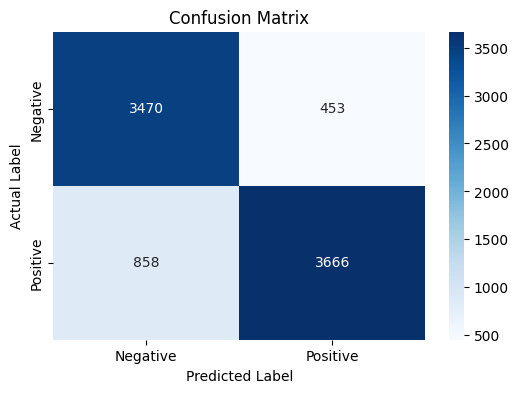

In [88]:
def plot_confusion_mix(model, X, y):
    # 1. Get binary predictions (0 or 1)
    y_pred = model.predict(X)
    
    # 2. Compute confusion matrix
    cm = confusion_matrix(y, y_pred)
    
    # 3. Plot using Seaborn for a clean look
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Run it
plot_confusion_mix(log_reg, X_test, y_test)

### **3. Churn via BG-NBD**

In [30]:
from lifetimes.utils import summary_data_from_transaction_data

summary = summary_data_from_transaction_data(
    df,
    customer_id_col="customer_id",
    datetime_col="transaction_date",
    monetary_value_col="amount",
    observation_period_end="2025-12-31"
)

summary.head()

,frequency,recency,T,monetary_value
customer_id,,,,
C00000,11.0,112.0,112.0,93.370000
C00001,17.0,278.0,289.0,68.373529
C00002,9.0,37.0,133.0,86.307778
C00003,3.0,45.0,88.0,19.393333
C00004,17.0,98.0,206.0,109.965882


In [71]:
summary.reset_index().shape

(2892, 5)

In [31]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(
    summary["frequency"],
    summary["recency"],
    summary["T"]
)

<lifetimes.BetaGeoFitter: fitted with 2892 subjects, a: 0.45, alpha: 10.41, b: 4.83, r: 1.46>

In [32]:
summary['p_alive'] = bgf.conditional_probability_alive(
    summary['frequency'],
    summary['recency'],
    summary['T']
)


summary['exp_txn_30d'] = bgf.predict(
    30,
    summary['frequency'],
    summary['recency'],
    summary['T']
)

In [33]:
summary.head()

,frequency,recency,T,monetary_value,p_alive,exp_txn_30d
customer_id,,,,,,
C00000,11.0,112.0,112.0,93.370000,0.970418,2.839422
C00001,17.0,278.0,289.0,68.373529,0.958491,1.739133
C00002,9.0,37.0,133.0,86.307778,0.000266,0.000562
C00003,3.0,45.0,88.0,19.393333,0.538345,0.701561
C00004,17.0,98.0,206.0,109.965882,0.000132,0.000330


In [95]:
df_final = summary.reset_index().merge(rfm_q, on='customer_id')

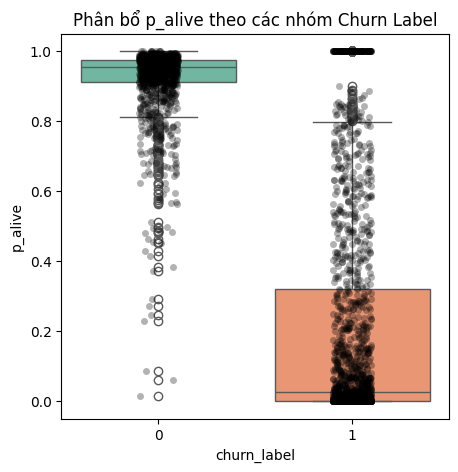

In [96]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='churn_label', y='p_alive', data=df_final, palette="Set2")
sns.stripplot(x='churn_label', y='p_alive', data=df_final, color="black", alpha=0.3) # Thêm các điểm dữ liệu thô
plt.title('Phân bổ p_alive theo các nhóm Churn Label')
plt.show()

### **4. Churn with Survival Analysis**

In [65]:
data = rfm_q.copy()

In [66]:
data['avg_amount'] = data['monetary']/data['frequency']

In [67]:
df1 = transactions.groupby('customer_id').agg(latest_txn_date=("transaction_date", max)).reset_index().merge(data,on='customer_id').merge(customers,on='customer_id')

In [68]:
df1['tenure'] = (
    (df1['latest_txn_date'] + pd.to_timedelta(INACTIVITY_WINDOW, unit='D'))
        .clip(upper=pd.Timestamp("2025-12-31"))
    - df1['signup_date']
).dt.days

In [69]:
df1.tail()

,customer_id,latest_txn_date,recency,frequency,monetary,R_score,F_score,M_score,RFM_score,rfm_segment,churn_label,avg_amount,signup_date,true_lifetime_days,tenure
2887,C02995,2025-12-31,1,15,460.70,5,4,3,543,Loyal Customers,0,30.713333,2025-10-05,303,87
2888,C02996,2025-11-28,34,9,638.36,3,3,3,333,Others,1,70.928889,2025-06-03,308,207
2889,C02997,2025-12-26,6,16,459.83,4,4,3,443,Loyal Customers,0,28.739375,2025-10-23,99,69
2890,C02998,2025-12-31,1,24,1505.03,5,4,5,545,Champions,0,62.709583,2025-10-25,174,67
2891,C02999,2025-12-30,2,75,2762.88,5,5,5,555,Champions,0,36.838400,2025-05-25,341,220


In [70]:
from lifelines import CoxPHFitter

features = ["frequency", "avg_amount"]

cph = CoxPHFitter()
cph.fit(
    df1[features + ["tenure", "churn_label"]],
    duration_col="tenure",
    event_col="churn_label"
)

cph.print_summary()

# Coefficients :
# - coef < 0 → feature giúp giảm hazard (giữ user lâu hơn)
# - exp(coef) = hazard ratio


<lifelines.CoxPHFitter: fitted with 2892 total observations, 1188 right-censored observations>
             duration col = 'tenure'
                event col = 'churn_label'
      baseline estimation = breslow
   number of observations = 2892
number of events observed = 1704
   partial log-likelihood = -11416.54
         time fit was run = 2026-01-19 04:02:49 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
frequency  -0.08      0.93      0.00           -0.08           -0.07                0.92                0.93
avg_amount -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

            cmp to      z      p  -log2(p)
covariate                                 
frequency     0.00 -25.66 <0.005    479.85
avg_amount    0.00  -0.27   0.79      0.34
---
Concordance = 0.80
Partial AIC = 22837.07
log-likelihood ratio test = 1080.79 on 2 df
-log2(p) of ll-ratio test = 779.63

In [71]:
from lifelines.utils import concordance_index

risk_pred = cph.predict_partial_hazard(df1[features])

c_index = concordance_index(
    df1["tenure"],
    -risk_pred,     # negative because higher risk = earlier event
    df1["churn_label"]
)

print(f"C-index: {c_index:.4f}")

# Rule of thumb:
# - 0.5 = random
# - 0.6–0.7 = usable
# - 0.7 = strong survival model


C-index: 0.8014


In [ ]:
from sksurv.metrics import integrated_brier_score
from sksurv.util import Surv

# Survival predictions
surv_funcs = cph.predict_survival_function(df1[features])

# VALID time grid (CRITICAL FIX)
t_min = df1.loc[df1["churn_label"] == 1, "tenure"].min()
t_max = df1["tenure"].max()

times = np.linspace(t_min, t_max * 0.999, 100)

# Convert survival funcs
surv_preds = np.asarray([
    np.interp(times, surv_funcs.index.values, surv_funcs.iloc[:, i].values)
    for i in range(surv_funcs.shape[1])
])

# IBS computation
y = Surv.from_arrays(
    event=df1["churn_label"].astype(bool),
    time=df1["tenure"]
)

ibs = integrated_brier_score(
    y,      # train
    y,      # test
    surv_preds,
    times
)

print(f"Integrated Brier Score: {ibs:.4f}")

# Interpretation:
# - IBS ↓ tốt hơn
# - 0 = perfect
# - ~0.1–0.2 = khá ổn cho churn survival


Integrated Brier Score: 0.1206


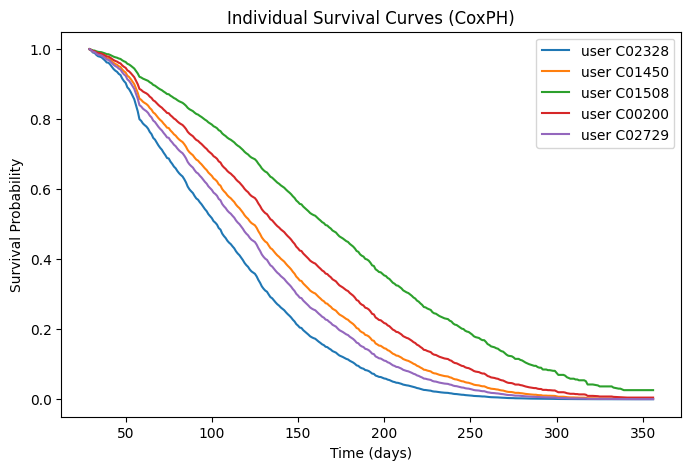

In [73]:
sample_users = df1.sample(5, random_state=1)

plt.figure(figsize=(8, 5))

for _, row in sample_users.iterrows():
    surv_fn = cph.predict_survival_function(row[features].to_frame().T)
    plt.plot(surv_fn.index, surv_fn.values.flatten(), label=f"user {row.customer_id}")

plt.title("Individual Survival Curves (CoxPH)")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

In [218]:
import numpy as np

rows = []
horizons = [30, 60, 90]

for _, row in df1.iterrows():
    surv_fn = cph.predict_survival_function(
        row[features].to_frame().T
    )

    t = surv_fn.index.values
    s = surv_fn.values.flatten()

    row_out = {"customer_id": row["customer_id"]}

    for h in horizons:
        surv_h = np.interp(h, t, s)
        row_out[f"surv_{h}d"] = surv_h
        row_out[f"churn_{h}d"] = 1 - surv_h

    rows.append(row_out)

survival_df = pd.DataFrame(rows)
df1 = df1.merge(survival_df, on='customer_id')

In [74]:
from lifelines import WeibullAFTFitter
raft = WeibullAFTFitter()
raft.fit(
    df1[features + ["tenure", "churn_label"]],
    duration_col="tenure",
    event_col="churn_label"
)
raft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 2892 total observations, 1188 right-censored observations>
             duration col = 'tenure'
                event col = 'churn_label'
   number of observations = 2892
number of events observed = 1704
           log-likelihood = -9846.22
         time fit was run = 2026-01-19 04:02:58 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                   
lambda_ avg_amount  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
        frequency   0.03      1.03      0.00            0.03            0.04                1.03                1.04
        Intercept   4.71    111.54      0.02            4.67            4.76              106.42              116.91
rho_    Intercept   0.82      2.28      0.02            0.79            0.86                2.20                2.36

                    cmp to      z      p  -log2(p)
param   covariate                                 
lambda_ avg_amount    0.00   0.29   0.78      0.37
        frequency     0.00  26.25 <0.005    502.03
        Intercept     0.00 196.73 <0.005       inf
rho_    Intercept     0.00  47.23 <0.005       inf
---
Concordance = 0.80
AIC = 19700.43
log-likelihood ratio test = 1139.27 on 2 df
-log2(p) of ll-ratio test = 821.81

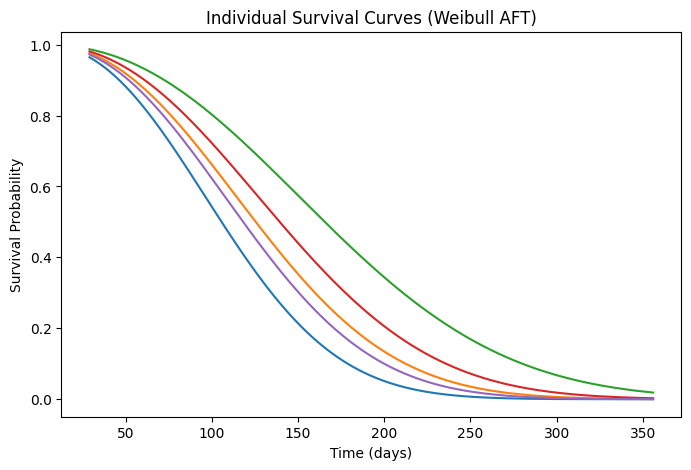

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for _, row in sample_users.iterrows():
    surv_fn = raft.predict_survival_function(row[features].to_frame().T)
    plt.plot(surv_fn.index, surv_fn.values.flatten(), label=f"User {row.customer_id}")

plt.title("Individual Survival Curves (Weibull AFT)")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.show()

In [76]:
def discounted_mean_residual_life(surv_col, t0, r):
    """
    surv_col: pd.Series, survival probabilities indexed by time
    t0: int, tenure at cutoff
    r: daily discount rate (e.g. 0.001)
    """

    # Ensure t0 is within survival horizon
    t0 = min(t0, surv_col.index.max())

    # Interpolate survival at t0
    S_t0 = np.interp(
        t0,
        surv_col.index.values,
        surv_col.values
    )

    # Future times
    mask = surv_col.index > t0
    t = surv_col.index[mask].values
    S = surv_col.loc[mask].values

    # Discounted area (time shifted to start at 0)
    discounted_area = np.trapz(
        S * np.exp(-r * (t - t0)),
        t
    )

    return discounted_area / S_t0

In [77]:
surv = raft.predict_survival_function(df1)

discounted_expected_remaining_days = []

for i, t0 in enumerate(df1["tenure"].values):
    surv_col = surv.iloc[:, i]
    discounted_expected_remaining_days.append(
        discounted_mean_residual_life(surv_col, t0, 0.01)
    )

df1["expected_remaining_days"] = discounted_expected_remaining_days


In [118]:
df1["expected_remaining_days"].describe()

count   2,892.0000
mean       46.6263
std        15.6181
min         0.0000
25%        36.0965
50%        44.2960
75%        54.5305
max        95.1162
Name: expected_remaining_days, dtype: float64

### **6. CLV Modelling**

#### 6.1 Approach BG-NBD + Gamma-Gamma

In [78]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef=0.01)

summary_gg = summary[summary["monetary_value"] > 0]

ggf.fit(
    summary_gg["frequency"],
    summary_gg["monetary_value"]
)

summary.loc[summary_gg.index, "expected_avg_order_value"] = (
    ggf.conditional_expected_average_profit(
        summary_gg["frequency"],
        summary_gg["monetary_value"]
    )
)

In [123]:
summary["CLV_3m"] = ggf.customer_lifetime_value(
    bgf,
    summary_gg["frequency"],
    summary_gg["recency"],
    summary_gg["T"],
    summary_gg["monetary_value"],
    time=3,               # 3 tháng
    discount_rate=0.01,   # discount rate
    freq="D"
)

summary["CLV_6m"] = ggf.customer_lifetime_value(
    bgf,
    summary_gg["frequency"],
    summary_gg["recency"],
    summary_gg["T"],
    summary_gg["monetary_value"],
    time=3,               # 6 tháng
    discount_rate=0.01,   # discount rate
    freq="D"
)

In [124]:
df1['CLV_3m'] = summary["CLV_3m"].values
df1['CLV_6m'] = summary["CLV_6m"].values

In [125]:
df1['CLV_3m'].describe()

count    2,755.0000
mean       424.1610
std        947.8724
min          0.0000
25%          0.9172
50%         70.5048
75%        471.4550
max     15,291.7010
Name: CLV_3m, dtype: float64

#### 6.2 Approach Survival Analysis + Gamma-Gamma

In [128]:
df1['expected_avg_transaction'] = summary['expected_avg_order_value'].values

In [129]:
df1['expected_remaining_lifetime_value'] = df1['expected_avg_transaction'] * df1['expected_remaining_days'] * df1['frequency']/df1['tenure']

In [135]:
df1['expected_remaining_lifetime_value'] = np.where(df1['churn_label'] == 1, 0, df1['expected_remaining_lifetime_value'])

In [136]:
df1[(df1['expected_remaining_lifetime_value'] > 0) & (df1['churn_label'] == 0)]['expected_remaining_lifetime_value'].describe()

count    1,176.0000
mean     1,466.1335
std      4,745.6018
min          1.6466
25%        178.3821
50%        462.9862
75%      1,219.0370
max     84,315.8349
Name: expected_remaining_lifetime_value, dtype: float64

## 💡 TOP 20 CUSTOMERS

In [199]:
N_CUSTOMER = int(customers.shape[0] * 0.2)

In [146]:
# High churn probability (classification)
PREDICTED_DATE = pd.Timestamp(2026,2,1)
data_ml = build_features(df, PREDICTED_DATE, HORIZON_DAY, INACTIVITY_WINDOW)

In [189]:
data_predicted = data_ml[data_ml['cutoff_date'] == data_ml['cutoff_date'].max()]

In [190]:
X_predicted = data_predicted.drop(columns=["customer_id", "cutoff_date"])

In [192]:
proba = model.predict_proba(X_predicted)[:, 1]

In [193]:
data_predicted['predicted_prob']  =  proba

In [238]:
data_predicted

,customer_id,recency_days,freq_30d,freq_90d,monetary_90d,freq_ratio,cutoff_date,predicted_prob
0,C00000,0,4,9,"1,222.8500",0.4444,2025-12-31,0.0241
1,C00001,11,3,8,"1,228.4600",0.3750,2025-12-31,0.4247
2,C00002,96,0,0,910.6400,0.0000,2025-12-31,0.9998
3,C00003,43,0,4,114.7100,0.0000,2025-12-31,0.8972
4,C00004,108,0,0,"2,018.9400",0.0000,2025-12-31,0.9999
...,...,...,...,...,...,...,...,...
2887,C02995,0,6,15,460.7000,0.4000,2025-12-31,0.0044
2888,C02996,33,0,3,638.3600,0.0000,2025-12-31,0.7704
2889,C02997,5,8,16,459.8300,0.5000,2025-12-31,0.0106
2890,C02998,0,15,24,"1,505.0300",0.6250,2025-12-31,0.0002


In [243]:
cols = ['recency','frequency','monetary']
data_predicted.merge(rfm, on='customer_id').sort_values(by='predicted_prob', ascending=False).iloc[:N_CUSTOMER][cols].describe(include='number')

,recency,frequency,monetary
count,600.0000,600.0000,600.0000
mean,181.7433,14.8067,959.7322
std,58.2597,11.5866,811.5245
min,64.0000,1.0000,15.0100
25%,136.0000,7.0000,412.8025
50%,177.0000,12.0000,702.3650
75%,223.2500,19.0000,"1,159.9225"
max,350.0000,105.0000,"4,813.9900"


In [256]:
# Low P(alive) (BG-NBD)
summary.reset_index()[['customer_id','p_alive']].merge(rfm, on='customer_id').sort_values(by='p_alive').iloc[:N_CUSTOMER][cols].describe()

,recency,frequency,monetary
count,600.0000,600.0000,600.0000
mean,189.7700,17.0833,957.7533
std,67.4367,14.1491,937.7240
min,33.0000,2.0000,3.4500
25%,139.0000,7.0000,330.2075
50%,187.0000,13.0000,677.6950
75%,239.2500,22.2500,"1,250.9275"
max,354.0000,108.0000,"6,289.5000"


In [250]:
# High CLV × High churn risk (Survival-based)
df1["score_60d"] = np.log1p(df1["expected_remaining_lifetime_value"]) * df1["churn_60d"]
df1.sort_values(by='score_60d', ascending=False).iloc[:N_CUSTOMER][cols].describe()


,recency,frequency,monetary
count,600.0000,600.0000,600.0000
mean,8.7967,10.6433,684.1576
std,7.5750,4.7519,564.8645
min,1.0000,2.0000,21.5200
25%,3.0000,7.0000,259.9225
50%,6.0000,11.0000,533.5600
75%,13.0000,14.0000,930.5025
max,29.0000,24.0000,"3,524.8000"
